<div style="text-align: right;"><h4>ФБ-21 Редько-Шпак Родислав</h4></div>
<h1><center>Лабораторна робота №7</center></h1>
<h3><center>З предмета "Засоби підготовки та аналізу даних"</center></h3>
<h5><b><center>Хід роботи:</center></b></h5>


In [1]:
import os
import shutil
import zipfile
import rasterio
import sklearn.metrics
import shapely.wkt
from sentinelhub import SHConfig
from sentinelhub.aws import request
from rasterio.plot import show

print("бібліотеки успішно імпортовані!")

бібліотеки успішно імпортовані!


<frozen abc>:106: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.


<h4> Завантаження Sentinel-2 та Landset</h4>

In [2]:
# (ROI) для Києва
kyiv_roi_wkt = "POLYGON((29.073321247506765 49.845775018245774,31.986007792928522 49.845775018245774,31.986007792928522 51.278667808079206,29.073321247506765 51.278667808079206,29.073321247506765 49.845775018245774))"

# Перевіряємо, чи ROI є валідним
kyiv_roi = shapely.wkt.loads(kyiv_roi_wkt)
if kyiv_roi.is_valid:
    print("ROI для Києва є валідним.")
else:
    print("ROI для Києва є невалідним.")
    
# Виводимо геометрію ROI
print(f"Геометрія ROI для Києва: {kyiv_roi.wkt}")

ROI для Києва є валідним.
Геометрія ROI для Києва: POLYGON ((29.073321247506765 49.845775018245774, 31.986007792928522 49.845775018245774, 31.986007792928522 51.278667808079206, 29.073321247506765 51.278667808079206, 29.073321247506765 49.845775018245774))


In [3]:
# створюємо папку "data", якщо її ще немає
data_dir = os.path.join(os.getcwd(), "data")
os.makedirs(data_dir, exist_ok=True)

config = SHConfig()
config.aws_access_key_id = 'ваш_access_key_id'
config.aws_secret_access_key = 'ваш_secret_access_key'

# завантаження даних Sentinel-2
print("Завантаження даних Sentinel-2")
product_id = "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206"
download_prompt = input(f"Завантажити '{product_id}'? (y/n) ")
if download_prompt.lower() == 'y':
    request.download_safe_format(product_id, folder=data_dir, redownload=False, data_collection='sentinel-s2-l2a')
else:
    print(f"Пропуск завантаження '{product_id}'")

product_id = "S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206"
download_prompt = input(f"Завантажити '{product_id}'? (y/n) ")
if download_prompt.lower() == 'y':
    request.download_safe_format(product_id, folder=data_dir, redownload=False, data_collection='sentinel-s2-l2a')
else:
    print(f"Пропуск завантаження '{product_id}'")


# завантаження даних Landset-8
print("Завантаження даних Landset-8")
product_id = "LC08_L1TP_182025_20190830_20190903_01_T1"
download_prompt = input(f"Завантажити '{product_id}'? (y/n) ")
if download_prompt.lower() == 'y':
    request.download_safe_format(product_id, folder=data_dir, redownload=False, data_collection='landsat-l1-tp')
else:
    print(f"Пропуск завантаження '{product_id}'")

product_id = "LC08_L1TP_182026_20190830_20190903_01_T1"
download_prompt = input(f"Завантажити '{product_id}'? (y/n) ")
if download_prompt.lower() == 'y':
    request.download_safe_format(product_id, folder=data_dir, redownload=False, data_collection='landsat-l1-tp')
else:
    print(f"Пропуск завантаження '{product_id}'")

Завантаження даних Sentinel-2
Пропуск завантаження 'S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206'
Пропуск завантаження 'S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206'
Завантаження даних Landset-8
Пропуск завантаження 'LC08_L1TP_182025_20190830_20190903_01_T1'
Пропуск завантаження 'LC08_L1TP_182026_20190830_20190903_01_T1'


<h4>Розархівувуємо Sentinel та Landset data</h4>

In [4]:
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'data')
full_data_dir = os.path.join(current_dir, 'full_data')

# чи існує папка full_data_dir
if os.path.exists(full_data_dir):
    user_confirm = input(f"Папка '{full_data_dir}' вже існує. Чи точно розархівувати дані? Усі наявні дані в цій папці будуть видалені (так/ні): ")
    if user_confirm.lower() == "так":
        shutil.rmtree(full_data_dir)
    else:
        print("Розархівування не знадобилося, дані вже є.")
        exit()

os.makedirs(full_data_dir, exist_ok=True)

# ф-ія для рекурсивного розархівування
def extract_recursive(zip_file_path, extract_to):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        for item in zip_ref.namelist():
            if item.endswith('.zip'):
                extract_recursive(os.path.join(extract_to, item), extract_to)
                os.remove(os.path.join(extract_to, item))

# розпаковуємо всі архіви в папці data
for zip_file in os.listdir(data_dir):
    if zip_file.endswith('.zip'):
        zip_file_path = os.path.join(data_dir, zip_file)
        extract_recursive(zip_file_path, full_data_dir)

# перейменовуємо папки з S2A_MSIL2A
for root, dirs, files in os.walk(full_data_dir):
    for dir_name in dirs:
        if dir_name.startswith("S2A_MSIL2A"):
            if "T36UUA" in dir_name:
                new_name = "data_sentinel_A"
            elif "T36UUB" in dir_name:
                new_name = "data_sentinel_B"
            else:
                continue
            os.rename(os.path.join(root, dir_name), os.path.join(root, new_name))

# перейменовуємо папки з LC08_L1TP_*
for root, dirs, files in os.walk(full_data_dir):
    for dir_name in dirs:
        if dir_name.startswith("LC08_L1TP_182025"):
            new_name = "data_lanset_A"
        elif dir_name.startswith("LC08_L1TP_182026"):
            new_name = "data_lanset_B"
        else:
            continue
        os.rename(os.path.join(root, dir_name), os.path.join(root, new_name))

print("Всі архіви успішно розпаковані та перейменовані в папці 'full_data'.")

Всі архіви успішно розпаковані та перейменовані в папці 'full_data'.


=======================================================================

<h1>Santinel-2</h1>

===================================================================

<h4>Конкатенація каналів видимого, ближнього та середнього інфрачервоного спектральних діапазонів (канали 2, 3, 4 та 8) зображення в єдиний GEOTIFF файл.<h4>


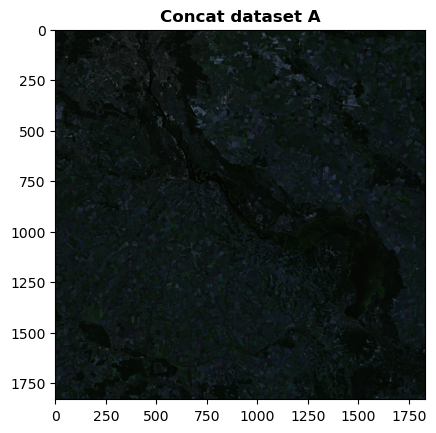

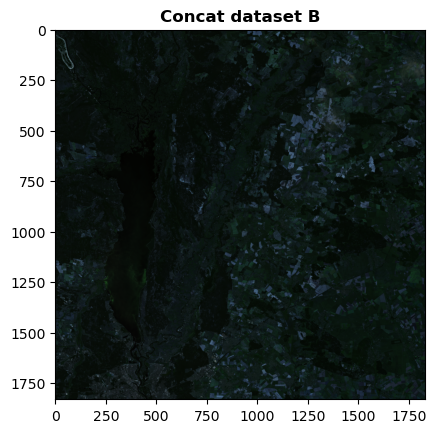

In [5]:
# файлові шляхи до даних sentinel
data_paths = {
    'A': {
        'B02': 'full_data/data_sentinel_A/GRANULE/L2A_T36UUA_A021740_20190821T085815/IMG_DATA/R60m/T36UUA_20190821T085601_B02_60m.jp2',
        'B03': 'full_data/data_sentinel_A/GRANULE/L2A_T36UUA_A021740_20190821T085815/IMG_DATA/R60m/T36UUA_20190821T085601_B03_60m.jp2',
        'B04': 'full_data/data_sentinel_A/GRANULE/L2A_T36UUA_A021740_20190821T085815/IMG_DATA/R60m/T36UUA_20190821T085601_B04_60m.jp2',
        'B8A': 'full_data/data_sentinel_A/GRANULE/L2A_T36UUA_A021740_20190821T085815/IMG_DATA/R60m/T36UUA_20190821T085601_B8A_60m.jp2'
    },
    'B': {
        'B02': 'full_data/data_sentinel_B/GRANULE/L2A_T36UUB_A021740_20190821T085815/IMG_DATA/R60m/T36UUB_20190821T085601_B02_60m.jp2',
        'B03': 'full_data/data_sentinel_B/GRANULE/L2A_T36UUB_A021740_20190821T085815/IMG_DATA/R60m/T36UUB_20190821T085601_B03_60m.jp2',
        'B04': 'full_data/data_sentinel_B/GRANULE/L2A_T36UUB_A021740_20190821T085815/IMG_DATA/R60m/T36UUB_20190821T085601_B04_60m.jp2',
        'B8A': 'full_data/data_sentinel_B/GRANULE/L2A_T36UUB_A021740_20190821T085815/IMG_DATA/R60m/T36UUB_20190821T085601_B8A_60m.jp2'
    }
}

# створення директорій для вихідних файлів
output_dirs = ['result_sentinel/sentinel_A', 'result_sentinel/sentinel_B']
for dir_path in output_dirs:
    os.makedirs(dir_path, exist_ok=True)

# об'єднання файлів за допомогою gdal_merge.py
for dataset, paths in data_paths.items():
    output_file = f'result_sentinel/sentinel_{dataset}/concat{dataset}.tif'
    gdal_merge_cmd = f'gdal_merge.py -o {output_file} -separate {" ".join(paths.values())}'
    os.system(gdal_merge_cmd)

merged_datasets = {
    dataset: rasterio.open(f'result_sentinel/sentinel_{dataset}/concat{dataset}.tif')
    for dataset in ['A', 'B']
}

for dataset, raster in merged_datasets.items():
    show(raster.read([1, 2, 3]), adjust=True, title=f'Concat dataset {dataset}')

<h4>Перепроектування супутникового зображення у проєкцію 4326.</h4>

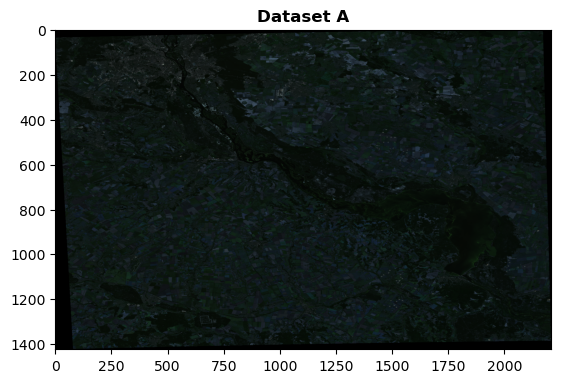

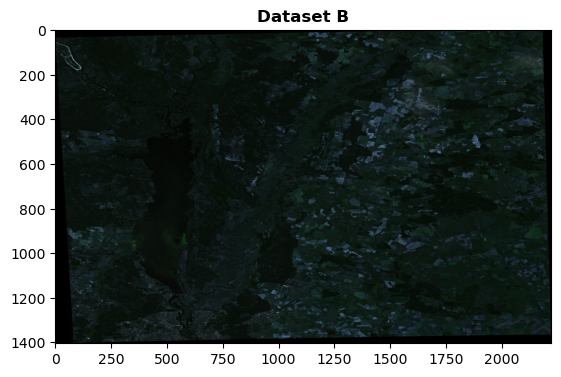

In [6]:
# перепроектування об'єднаних файлів за допомогою gdalwarp
for dataset in ['A', 'B']:
    input_file = f'result_sentinel/sentinel_{dataset}/concat{dataset}.tif'
    output_file = f'result_sentinel/sentinel_{dataset}/pr{dataset}_4326.tif'
    gdalwarp_cmd = f'gdalwarp -t_srs EPSG:4326 {input_file} {output_file}'
    os.system(gdalwarp_cmd)

projected_datasets = {
    dataset: rasterio.open(f'result_sentinel/sentinel_{dataset}/pr{dataset}_4326.tif')
    for dataset in ['A', 'B']
}

for dataset, raster in projected_datasets.items():
    show(raster.read([1, 2, 3]), adjust=True, title=f'Dataset {dataset}')

<h4>Конкатенація всіх отриманих растрів у один 4-канальний файл TIFF.</h4>

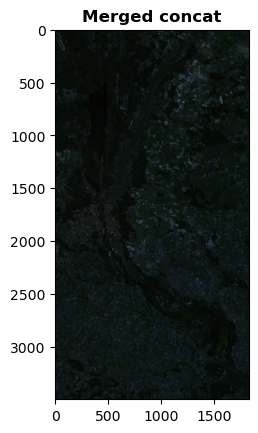

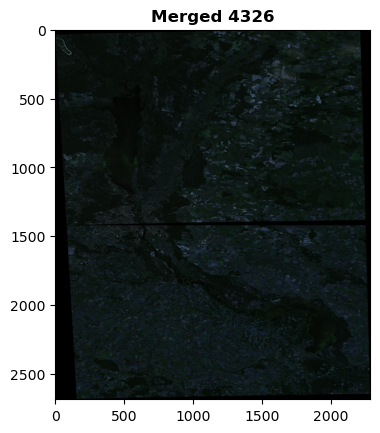

In [7]:
# додаткове об'єднання перепроектованих файлів за допомогою gdal_merge.py
gdal_merge_cmd = 'gdal_merge.py -o result_sentinel/sentinel_A/full_concat.tif result_sentinel/sentinel_A/concatA.tif result_sentinel/sentinel_B/concatB.tif'
os.system(gdal_merge_cmd)

gdal_merge_cmd = 'gdal_merge.py -o result_sentinel/sentinel_B/full_4326.tif result_sentinel/sentinel_A/prA_4326.tif result_sentinel/sentinel_B/prB_4326.tif'
os.system(gdal_merge_cmd)

merged_all = {
    'concat': rasterio.open('result_sentinel/sentinel_A/full_concat.tif'),
    '4326': rasterio.open('result_sentinel/sentinel_B/full_4326.tif')
}

for name, raster in merged_all.items():
    show(raster.read([1, 2, 3]), adjust=True, title=f'Merged {name}')

<h4>Обріжте зображення за вашим векторним файлом використовуючи gdalwarp</h4>

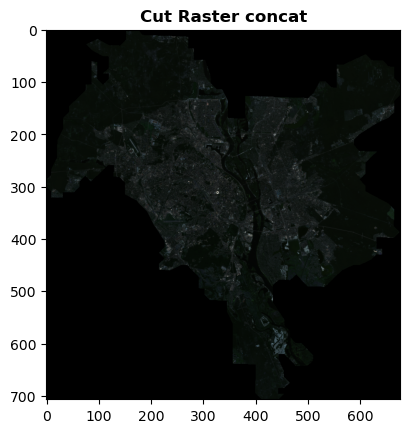

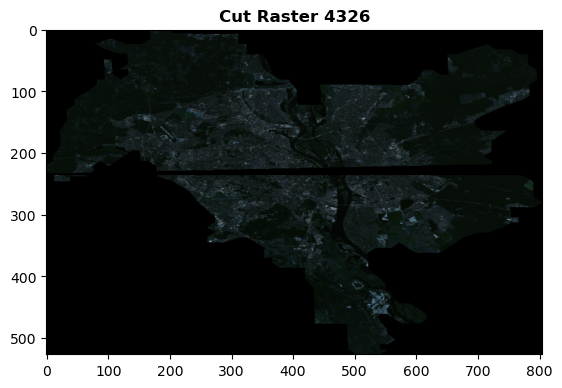

In [8]:
# обрізання файлу за shapefile за допомогою gdalwarp
gdalwarp_cmd = 'gdalwarp -cutline full_data/Kyiv_regions.shp -crop_to_cutline result_sentinel/sentinel_A/full_concat.tif result_sentinel/cut_concat.tif'
os.system(gdalwarp_cmd)

gdalwarp_cmd = 'gdalwarp -cutline full_data/Kyiv_regions.shp -crop_to_cutline result_sentinel/sentinel_B/full_4326.tif result_sentinel/cut_4326.tif'
os.system(gdalwarp_cmd)

cut_all = {
    'concat': rasterio.open('result_sentinel/cut_concat.tif'),
    '4326': rasterio.open('result_sentinel/cut_4326.tif')
}

for name, raster in cut_all.items():
    show(raster.read([1, 2, 3]), adjust=True, title=f'Cut Raster {name}')

===================================================================

<h1>Landset</h1>

===================================================================

<h4>Конкатенація каналів видимого, ближнього та середнього інфрачервоного спектральних діапазонів (канали 2, 3, 4 та 8) зображення в єдиний GEOTIFF файл.</h4>

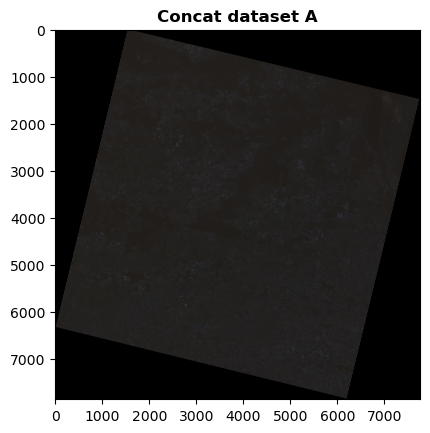

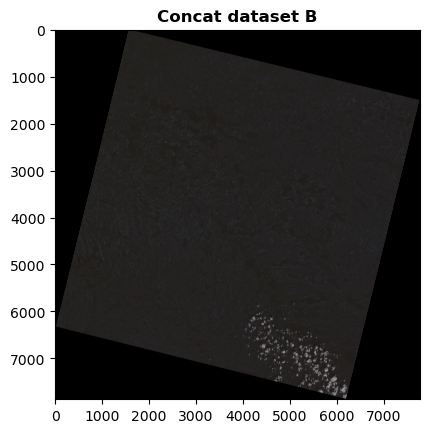

In [9]:
# файлові шляхи до даних landset
data_paths = {
    'A': {
        'B2': 'full_data/data_lanset_A/LC08_L1TP_182025_20190830_20190903_01_T1_B2.TIF',
        'B3': 'full_data/data_lanset_A/LC08_L1TP_182025_20190830_20190903_01_T1_B3.TIF',
        'B4': 'full_data/data_lanset_A/LC08_L1TP_182025_20190830_20190903_01_T1_B4.TIF',
        'B8': 'full_data/data_lanset_A/LC08_L1TP_182025_20190830_20190903_01_T1_B8.TIF'
    },
    'B': {
        'B2': 'full_data/data_lanset_B/LC08_L1TP_182026_20190830_20190903_01_T1_B2.TIF',
        'B3': 'full_data/data_lanset_B/LC08_L1TP_182026_20190830_20190903_01_T1_B3.TIF',
        'B4': 'full_data/data_lanset_B/LC08_L1TP_182026_20190830_20190903_01_T1_B4.TIF',
        'B8': 'full_data/data_lanset_B/LC08_L1TP_182026_20190830_20190903_01_T1_B8.TIF'
    }
}

# створення директорій для вихідних файлів
output_dirs = ['result_landset/lanset_A', 'result_landset/lanset_B']
for dir_path in output_dirs:
    os.makedirs(dir_path, exist_ok=True)

# об'єднання файлів за допомогою gdal_merge.py
for dataset, paths in data_paths.items():
    output_file = f'result_landset/lanset_{dataset}/concat{dataset}.tif'
    gdal_merge_cmd = f'gdal_merge.py -o {output_file} -separate {" ".join(paths.values())}'
    os.system(gdal_merge_cmd)

merged_datasets = {
    dataset: rasterio.open(f'result_landset/lanset_{dataset}/concat{dataset}.tif')
    for dataset in ['A', 'B']
}

for dataset, raster in merged_datasets.items():
    show(raster.read([1, 2, 3]), adjust=True, title=f'Concat dataset {dataset}')

<h4>Перепроектування супутникового зображення у проєкцію 4326.</h4>

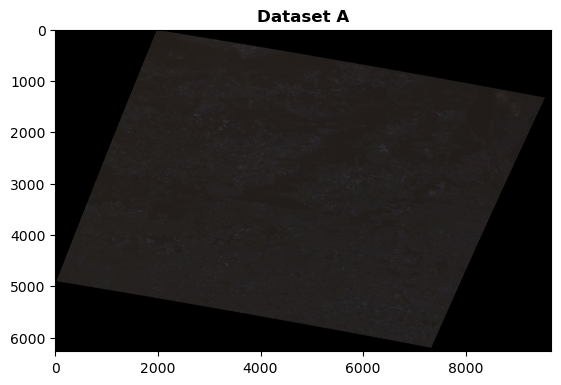

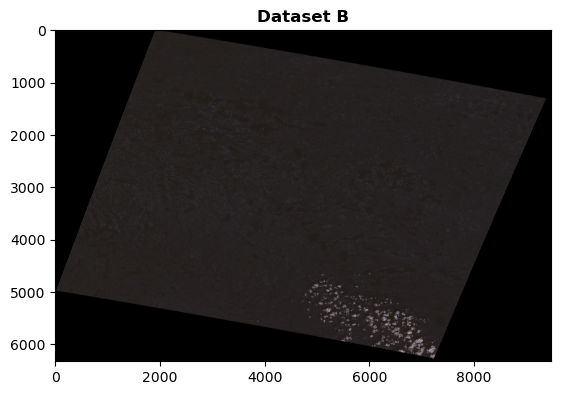

In [10]:
# перепроектування об'єднаних файлів за допомогою gdalwarp
for dataset in ['A', 'B']:
    input_file = f'result_landset/lanset_{dataset}/concat{dataset}.tif'
    output_file = f'result_landset/lanset_{dataset}/pr{dataset}_4326.tif'
    gdalwarp_cmd = f'gdalwarp -t_srs EPSG:4326 {input_file} {output_file}'
    os.system(gdalwarp_cmd)

projected_datasets = {
    dataset: rasterio.open(f'result_landset/lanset_{dataset}/pr{dataset}_4326.tif')
    for dataset in ['A', 'B']
}

for dataset, raster in projected_datasets.items():
    show(raster.read([1, 2, 3]), adjust=True, title=f'Dataset {dataset}')

<h4>Конкатенація всіх отриманих растрів у один 4-канальний файл TIFF.</h4>

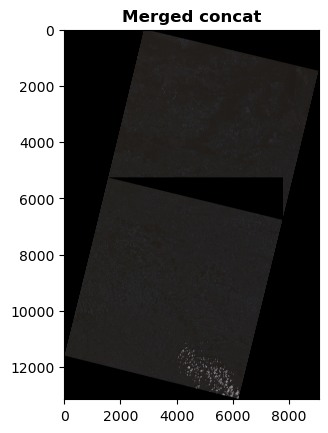

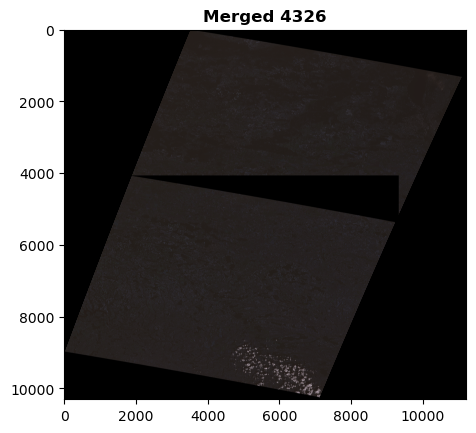

In [11]:
# об'єднання перепроектованих файлів за допомогою gdal_merge.py
gdal_merge_cmd = 'gdal_merge.py -o result_landset/lanset_A/full_concat.tif result_landset/lanset_A/concatA.tif result_landset/lanset_B/concatB.tif'
os.system(gdal_merge_cmd)

gdal_merge_cmd = 'gdal_merge.py -o result_landset/lanset_B/full_4326.tif result_landset/lanset_A/prA_4326.tif result_landset/lanset_B/prB_4326.tif'
os.system(gdal_merge_cmd)

merged_all = {
    'concat': rasterio.open('result_landset/lanset_A/full_concat.tif'),
    '4326': rasterio.open('result_landset/lanset_B/full_4326.tif')
}

for name, raster in merged_all.items():
    show(raster.read([1, 2, 3]), adjust=True, title=f'Merged {name}')

<h4>Переведіть панхроматичний канал у 30 м, а RGB канали у 60 метрів.</h4>

In [12]:
output_dir = 'result_landset/pansharpen'
os.makedirs(output_dir, exist_ok=True)

# переведення панхроматичного каналу у 30 м
gdal_translate_cmd = 'gdal_translate -tr 30 30 full_data/data_lanset_A/LC08_L1TP_182025_20190830_20190903_01_T1_B8.tif result_landset/pansharpen/panchromatic_30.tif'
os.system(gdal_translate_cmd)

# переведення RGB каналів у 60 м
gdal_translate_cmd = 'gdal_translate -tr 60 60 result_landset/lanset_A/concatA.tif result_landset/pansharpen/rgb_60.tif'
os.system(gdal_translate_cmd)

0

<h4>Після цього паншарпніть 60 метровий RGB за допомогою 30 м панхроматичного каналу.</h4>

In [13]:
# паншарпенінг 60 метрового RGB за допомогою 30 м панхроматичного каналу
pansharpen_methods = ['average', 'nearest', 'bilinear', 'cubic', 'cubicspline', 'lanczos']

for method in pansharpen_methods:
    output_file = f'result_landset/pansharpen/pansharpen_{method}.tif'
    gdal_pansharpen_cmd = f'gdal_pansharpen.py -r {method} result_landset/pansharpen/panchromatic_30.tif result_landset/pansharpen/rgb_60.tif {output_file}'
    os.system(gdal_pansharpen_cmd)


<h4>Підрахуйте метрики точності паншарпенінгу</h4>

In [14]:
# відкриття результатів паншарпенінгу
pansharpen_methods = {
    'average': rasterio.open('result_landset/pansharpen/pansharpen_average.tif').read().flatten(),
    'nearest': rasterio.open('result_landset/pansharpen/pansharpen_nearest.tif').read().flatten(),
    'bilinear': rasterio.open('result_landset/pansharpen/pansharpen_bilinear.tif').read().flatten(),
    'cubic': rasterio.open('result_landset/pansharpen/pansharpen_cubic.tif').read().flatten(),
    'cubicspline': rasterio.open('result_landset/pansharpen/pansharpen_cubicspline.tif').read().flatten(),
    'lanczos': rasterio.open('result_landset/pansharpen/pansharpen_lanczos.tif').read().flatten()
}

# відкриття вихідного файлу для порівняння
reference = rasterio.open('result_landset/lanset_A/concatA.tif').read().flatten()

# коефіцієнти детермінації (R^2) для кожного методу паншарпенінгу
similarity_scores = {
    method: sklearn.metrics.r2_score(reference, data)
    for method, data in pansharpen_methods.items()
}

# Виведення результатів
print("Коефіцієнти детермінації (R^2) для кожного методу паншарпенінгу:")
for method, score in similarity_scores.items():
    print(f"{method.capitalize():12}: {score}")

Коефіцієнти детермінації (R^2) для кожного методу паншарпенінгу:
Average     : 0.99883319358176
Nearest     : 0.99883798103681
Bilinear    : 0.998832056552446
Cubic       : 0.9988357559781565
Cubicspline : 0.9988288467141183
Lanczos     : 0.9988390409595908


In [15]:
# Знайти найкращий метод паншарпенінгу за коефіцієнтом детермінації
best_method = max(similarity_scores, key=similarity_scores.get)
best_score = similarity_scores[best_method]

print(f"Найкращий метод паншарпенінгу: {best_method.capitalize()}")
print(f"Коефіцієнт детермінації (R^2): {best_score}")

Найкращий метод паншарпенінгу: Lanczos
Коефіцієнт детермінації (R^2): 0.9988390409595908
